In [10]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [9]:
import sys, os, time, re
import numpy as np
import pickle
import matplotlib.pyplot as plt
import emcee
import corner
import pandas as pd
from multiprocessing import Pool
import matplotlib as m
import scipy as sp
m.rcParams.update({'font.size': 14})

from ksz.parameters import *

In [472]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
#colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [144]:
CL = 95
percentile1=(100-CL)/2
percentile2=CL+(100-CL)/2
smoothing = 3.

## Model parameter set

In [479]:
sims = []
for filename in os.listdir('/Users/emcbride/spectra/kSZ/LoReLi'):
    #files_LoReLi.append(filename)
    match = re.search(r'\d{5}', filename)
    sims.append(match.group())

print(f'{len(sims)} sims available')

1173 sims available


In [480]:
#df = pd.read_csv('/Users/emcbride/catwoman/scripts/Loreli_data.db')
df = pd.read_csv('/Users/emcbride/kSZ/data/LoreLi_summaries/Loreli_data.db')
df.set_index('sim_n', inplace=True)
df.index = df.index.astype(str)
df.drop(columns='Unnamed: 0', inplace=True)

Take a look at simu12031!
Take a look at simu12723!
Take a look at simu12716!
Take a look at simu17225!


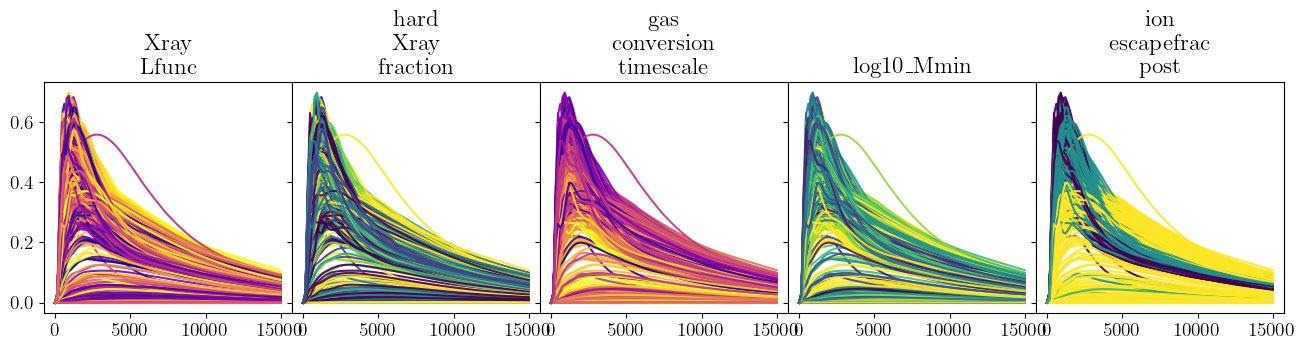

In [481]:
fig, ax = plt.subplots(1,5, sharex=True, sharey=True, figsize=(16,3))
fig.subplots_adjust(wspace=0.0, hspace=0.0)

params_to_regress = astro_labels # currently just all
baddies = []
for i, pname in enumerate(params_to_regress):
    if (pname == params_to_regress[0]) or (pname == params_to_regress[2]):
        norm = matplotlib.colors.LogNorm(vmin=df[pname].min(), vmax=df[pname].max())
        cmap = plt.get_cmap('plasma') 
    else:   
        norm = matplotlib.colors.Normalize(vmin=df[pname].min(), vmax=df[pname].max())
        cmap = plt.get_cmap('viridis_r')

    # legend_handles = []
    fesc_vals = df[params_to_regress[-1]].unique()
    for j, sn in enumerate(sims):
        # if df.loc[sn][params_to_regress[-1]] == fesc_vals[0]:
        #     axes = ax[0]
        # if df.loc[sn][params_to_regress[-1]] == fesc_vals[1]:
        #     axes = ax[1]
        # if df.loc[sn][params_to_regress[-1]] == fesc_vals[2]:
        #     axes = ax[2]
        #fn_G = f'/home/emc-brid/spectra/kSZ/Gorce/kSZ_Gorce_simu{sn}.npz'
        fn_L = f'/Users/emcbride/spectra/kSZ/LoReLi/kSZ_LoReLi_simu{sn}.npz'
        
       # Gorce = np.load(fn_G)
        LoReLi = np.load(fn_L)

        
        if np.max(LoReLi['kSZ']) > .75:
            if i == 0:
                print(f'Take a look at simu{sn}!')
                baddies.append(sn)
            continue
            
        #ax[0,i].plot(Gorce['ells'], Gorce['kSZ'], color=cmap(norm(df.loc[sn][pname])))
        ax[i].plot(LoReLi['ells'], LoReLi['kSZ'], color=cmap(norm(df.loc[sn][pname])), alpha=.9)
    
        # if np.isclose(df.loc[sn][pname], unique).any():
        #     label = f"Value: {df.loc[sn][pname]:.5f}"
        #     legend_handles.append(plt.Line2D([0], [0], color=cmap(norm(df.loc[sn][pname])), label=label))
  #  ax[i].axhline(.5, color='gray')
    # ax[i].legend(handles=legend_handles, title="Legend")

    ax[i].set_title(astro_labels_formatted[i])

In [482]:
baddies

['12031', '12723', '12716', '17225']

In [483]:
df = df.loc[sims]
df = df.drop(baddies)
df = df[astro_labels]
df

,Xray_Lfunc,hard_Xray_fraction,gasconversion_timescale,log10_Mmin,ion_escapefrac_post
sim_n,,,,,
17038,0.000614,0.0,1998.1,9.60,0.500
11449,0.002822,0.6,2493.8,9.07,0.275
16454,0.006067,0.8,934.8,9.33,0.050
10025,0.000883,0.2,8191.9,8.00,0.275
11313,0.008909,1.0,3991.4,8.53,0.275
...,...,...,...,...,...
11444,0.001920,0.8,2493.8,9.07,0.275
17035,0.000422,0.6,1998.1,9.60,0.500
10028,0.000883,0.8,8191.9,8.00,0.275


ells new length 50
ells new length 25
ells new length 20
ells new length 50
ells new length 25
ells new length 20
ells new length 50
ells new length 25
ells new length 20
ells new length 50
ells new length 25
ells new length 20
ells new length 50
ells new length 25
ells new length 20


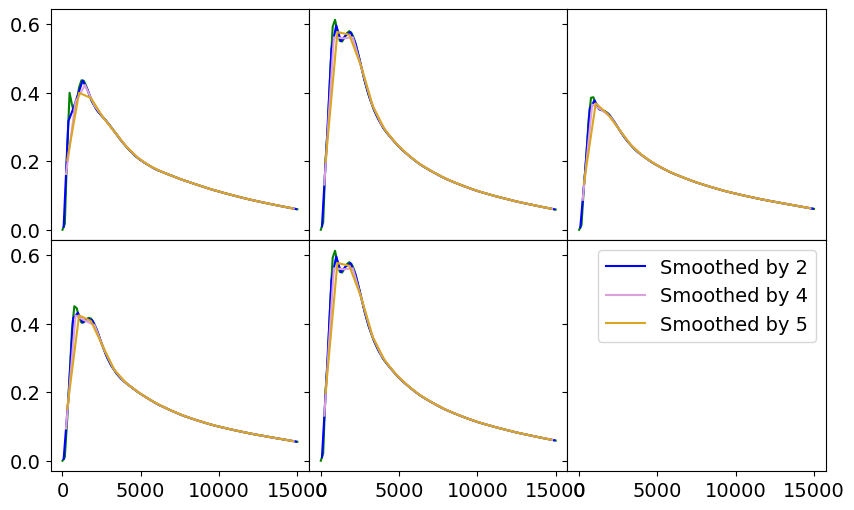

In [279]:
sims_choppy = ['10277', '13141', '10083', '11647', '13141']

fig, ax = plt.subplots(2,3, figsize=(10,6), sharex=True, sharey=True)
ax = ax.ravel()

fig.subplots_adjust(wspace=0.0, hspace=0.0)
for i, sn in enumerate(sims_choppy):
    spectra = np.load(f'/Users/emcbride/spectra/kSZ/LoReLi/kSZ_LoReLi_simu{sn}.npz')

    ax[i].plot(spectra['ells'], spectra['kSZ'], color=colors[0])

    for ci, average in enumerate([2,4,5]):
        ells_new = []
        kSZ_new = []
        for l in range(0, spectra['ells'].size, average):
            s = np.sum([spectra['kSZ'][l+j] for j in range(average)]) / average
            ell = np.sum([spectra['ells'][l+j] for j in range(average)]) / average

            ells_new.append(ell)
            kSZ_new.append(s)
        
        print(f'ells new length {len(ells_new)}')
            


        ax[i].plot(ells_new, kSZ_new, color=colors[ci + 1], label=f'Smoothed by {average}')
        if i == 0:
            ax[-1].plot([], color=colors[ci + 1], label=f'Smoothed by {average}')

ax[-1].legend()

In [359]:
fesc_vals
df = df[df[astro_labels[-1]] == fesc_vals[1]]

In [366]:
# parameters of the model
labels = astro_pnames_formatted[:]
paramnames = astro_pnames[:]
theta_ref = df[astro_labels].mean().to_list()[:] # mean values
ndim = len(theta_ref)

Distribution of model parameters

In [367]:
# shape is (ndim, nsamples)
params = df[astro_labels].to_numpy().T[:]
print(params.shape)
for i in range(len(params)):
    print('%.4f < %s < %.4f' %(np.min(params[i,:]),paramnames[i],np.max(params[i,:])))

(5, 1013)
0.0002 < L_X < 0.0192
0.0000 < f_X < 1.0000
738.9000 < tau < 10504.7000
8.0000 < Mmin < 9.6000
0.0500 < f_esc < 0.5000


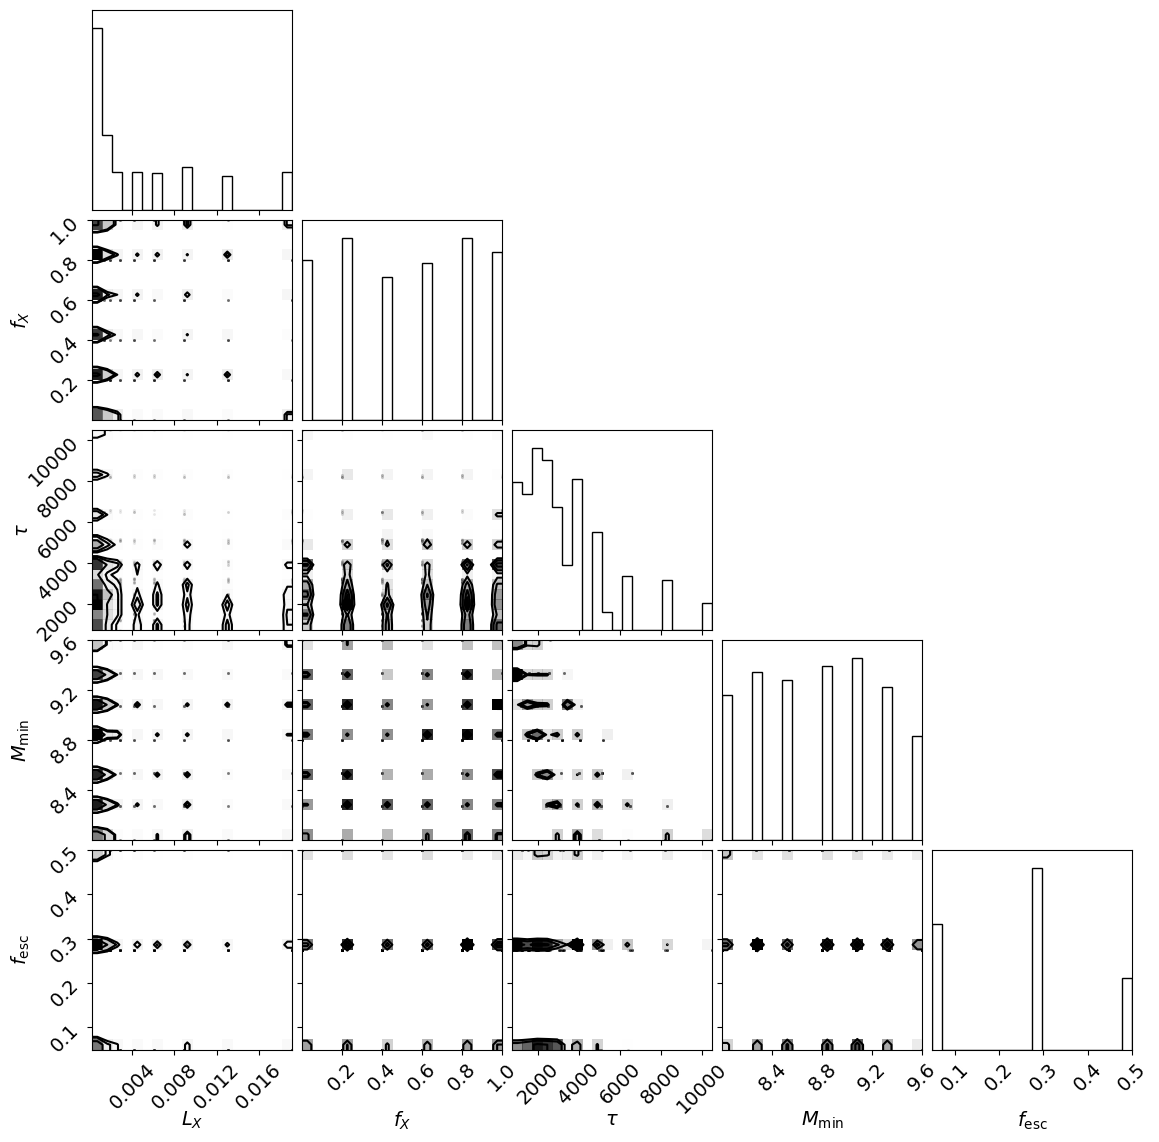

In [368]:
_ = corner.corner(params.T, labels=labels)#,extents=priors)

## Training set

In [487]:
# Build dataset
# shape (nsamples, nells)
ells = np.linspace(1,15000, 100)
ells_avg = []
ksz_avg = []

samples = df.index.tolist() # this is all the sims that are usable for training

for ci, average in enumerate([2,4,5]):
    pksz = np.zeros((len(samples), int(len(ells) / average)))
    print(pksz.shape)
    for i, sn in enumerate(samples):
        fn = f'/Users/emcbride/spectra/kSZ/LoReLi/kSZ_LoReLi_simu{sn}.npz'
        spectra = np.load(fn)

        ells_new = []
        kSZ_new = []
        for l in range(0, spectra['ells'].size, average):
            s = np.sum([spectra['kSZ'][l+j] for j in range(average)]) / average
            ell = np.sum([spectra['ells'][l+j] for j in range(average)]) / average

            ells_new.append(ell)
            kSZ_new.append(s)

        pksz[i] = kSZ_new
    
    ksz_avg.append(pksz)
    ells_avg.append(ells_new)

(1169, 50)
(1169, 25)
(1169, 20)


In [490]:
pksz.shape

(1169, 20)

In [488]:
# resulting C_ells
i3000 = np.argmin(abs(ells-3000))
print(ells[i3000])

D3000 = pksz[:, i3000]
print('D3000 = %.3f +/- %.3f' %(np.median(D3000), np.std(D3000)))

D_ells = np.copy(pksz)
nsamp = D_ells.shape[0]

3031.1010101010097


IndexError: index 20 is out of bounds for axis 1 with size 20

<>:4: SyntaxWarning: invalid escape sequence '\e'
<>:5: SyntaxWarning: invalid escape sequence '\e'
<>:4: SyntaxWarning: invalid escape sequence '\e'
<>:5: SyntaxWarning: invalid escape sequence '\e'
/var/folders/8t/k878xr_j2fqgy_993tg3qy7c0000gn/T/ipykernel_52791/3784208834.py:4: SyntaxWarning: invalid escape sequence '\e'
  plt.ylabel('$\\frac{\ell(\ell+1)}{2 \pi} C_\ell^{kSZ}$', fontsize='x-large')
/var/folders/8t/k878xr_j2fqgy_993tg3qy7c0000gn/T/ipykernel_52791/3784208834.py:5: SyntaxWarning: invalid escape sequence '\e'
  plt.xlabel('Multipole $\ell$')


Text(0.5, 0, 'Multipole $\\ell$')

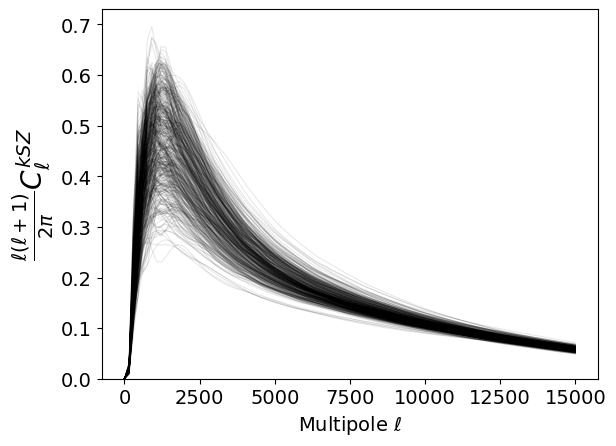

In [ ]:
plt.figure()
plt.plot(ells, pksz.T, lw=.7, color='k', alpha=.1)
plt.ylim(bottom=0.)
plt.ylabel('$\\frac{\ell(\ell+1)}{2 \pi} C_\ell^{kSZ}$', fontsize='x-large')
plt.xlabel('Multipole $\ell$')

## ML training

In [190]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.linear_model import LogisticRegression

Training

In [484]:
pksz = ksz_avg[1]
ells = ells_avg[1]
print(f'size {pksz.shape}')

size (1013, 25)


In [439]:
np.save('ells_for_regressor', ells)

In [485]:
#training set
X_train, X_test, y_train, y_test = train_test_split(params.T, pksz, test_size=0.20, random_state=0)

In [486]:
X_train.shape

(810, 5)

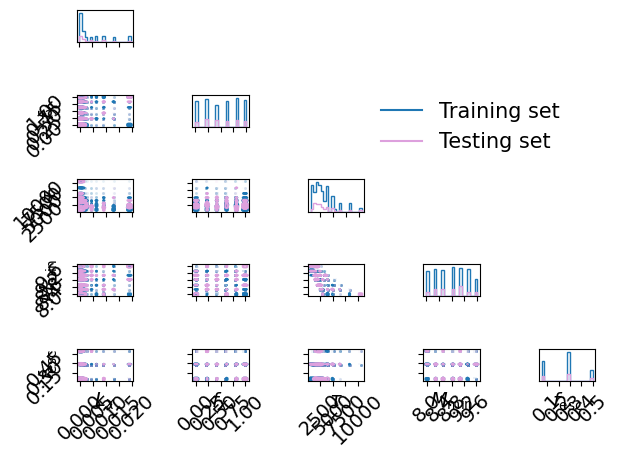

In [455]:
colors = ['#1f77b4','plum','gold']
cmaps = ['Blues','PuRd','Wistia']
datasets = ['Training set', 'Testing set']
fig, axes = plt.subplots(len(params),len(params))
for i in range(len(datasets)):
    axes[-1,-1].plot([],[],label=datasets[i],color=colors[i])

corner.corner(X_train,color=colors[0],labels=labels,cmap=cmaps[0],fig=fig)
corner.corner(X_test,color=colors[1],labels=labels,cmap=cmaps[1],fig=fig,alpha=.5)

fig.legend(loc=(0.6,0.65),frameon=False,fontsize=15)
fig.tight_layout()
# fig.savefig('Training_testing_sets_%s.png' %seed)

In [456]:
# training
regressor = RandomForestRegressor(n_estimators=1000, max_depth=20, random_state=0)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print("score",regressor.score(X_test,y_test))

Mean Absolute Error: 0.0073389434500430095
Mean Squared Error: 0.00013235088639439445
Root Mean Squared Error: 0.011504385528762259
score 0.9223836277185019


In [457]:
#mean absolute error per l bin
MAE = np.mean(np.abs(y_test-y_pred),axis=0)
#root mean squared error per l bin
RMSE = np.sqrt(np.sum((y_test-y_pred)**2,axis=0)/y_test.shape[0])

RMSE has the benefit of penalizing large errors more so can be more appropriate in some cases, for example, if being off by 10 is more than twice as bad as being off by 5. But if being off by 10 is just twice as bad as being off by 5, then MAE is more appropriate

In [458]:
err = np.std(np.abs(y_test-y_pred),axis=0)
ratio = y_pred/y_test
a68, b68 = np.percentile(ratio,percentile1,axis=0), np.percentile(ratio,percentile2,axis=0)
MAE2 = np.mean(np.abs(ratio-1)*y_pred,axis=0)

(0.0, 0.025605993953658212)

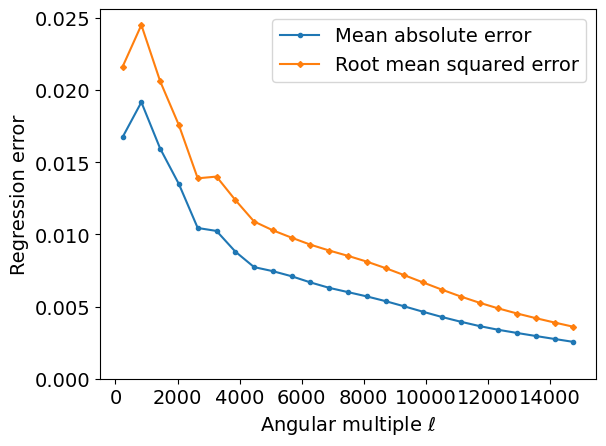

In [459]:
plt.figure()
plt.plot(ells,MAE,marker='o',markersize=3,label='Mean absolute error')
plt.plot(ells,RMSE,marker='D',markersize=3,label='Root mean squared error')
plt.legend()
plt.xlabel(r'Angular multiple $\ell$')
plt.ylabel(r'Regression error')
plt.ylim(bottom=0)

In [461]:
# Get numerical feature importances
importances = list(regressor.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(paramnames, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: f_esc                Importance: 0.49
Variable: tau                  Importance: 0.34
Variable: L_X                  Importance: 0.08
Variable: Mmin                 Importance: 0.06
Variable: f_X                  Importance: 0.03


IndexError: index 20 is out of bounds for axis 1 with size 20

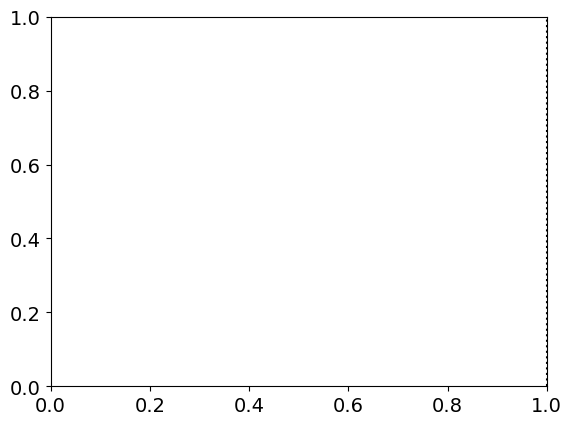

In [380]:
fig, ax = plt.subplots(1,1)
ax.axvline(1,color='k',ls=':')
ax.hist(
    y_pred[:, i3000]/y_test[:, i3000],
    histtype='step', lw=2, color='C0', bins=50,
)
ax.axvspan(0.95, 1.05, color='k', alpha=0.15)
ax.set_ylabel(r"PDF", fontsize=15)
ax.set_xlabel(r"$\mathcal{D}_{3000}^\mathrm{pred}/\mathcal{D}_{3000}^\mathrm{input}$", fontsize=15)
ax.tick_params(labelsize=14)
# plt.xlim(0, 2)
fig.tight_layout()

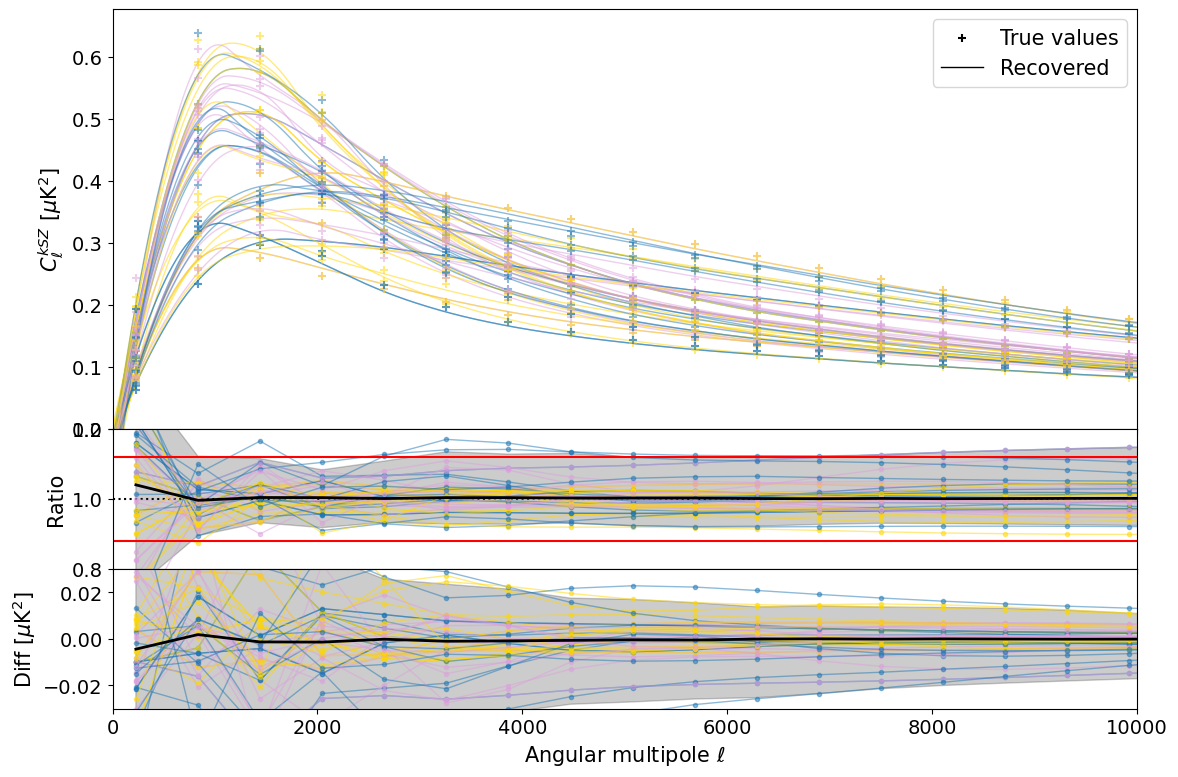

In [462]:
# plot Cls true and Cls predicted with errors

new_length = 9991
new_xx = np.linspace(1, 11000, 11000)

# pick random subset of 50 parameters among the test set 
subset_indices = np.random.randint(low=0, high=y_test.shape[0], size=50)

fig, axes = plt.subplots(3,1,figsize=(12,8),sharex=True,gridspec_kw={'height_ratios':(3,1,1),'hspace':0})
axes[1].axhline(1,color='k',ls=':')
for i, ind in enumerate(subset_indices):
    color = np.take(colors, i, mode='wrap')
    # plot true spectra for parameter set
    # rescale to true amplitudes (without alpha_i)
    ytrue = y_test[ind]
    axes[0].scatter(ells,ytrue, marker="+", color=color, s=30, zorder=2,alpha=.5)
    # plot predicted spectra for parameter set
    yrecons = y_pred[ind]
    # interpolated version to look nice
    new_yy = sp.interpolate.interp1d(ells,y_pred[ind,:] , kind='quadratic', fill_value='extrapolate')(new_xx)
    #new_yy = new_yy*(exponents[0]*np.prod(np.abs(X_test[ind,:]/theta_ref)**exponents[1:]))
    axes[0].plot(new_xx,new_yy, "-", color=color, lw=1., zorder=1,alpha=.5)
    # ratio of pred to true
    axes[1].plot(ells,y_pred[ind,:]/y_test[ind,:],marker='o',color=color,lw=1,markersize=3,alpha=.5)
    # diff between pred and true
    axes[2].plot(ells,ytrue-yrecons,marker='o',color=color,lw=1,markersize=3,alpha=.5)

# uncertainties on ratio
a68, b68 = np.percentile(y_pred/y_test,percentile1,axis=0), np.percentile(y_pred/y_test,percentile2,axis=0)
axes[1].fill_between(ells, b68, a68, color='k',alpha=0.2)
axes[1].plot(ells,np.median(ratio,axis=0),color='k', linestyle='-', linewidth=2)
# uncertainties on difference
ratio2 = (y_test - y_pred)#*(exponents[0]*np.prod(np.abs(X_test/theta_ref)**exponents[1:],axis=1))[:,None]
a682, b682 = np.percentile(ratio2,percentile1,axis=0), np.percentile(ratio2,percentile2,axis=0)
axes[2].fill_between(ells, b682, a682, color='k',alpha=0.2)
axes[2].plot(ells,np.median(ratio2,axis=0),color='k', linestyle='-', linewidth=2)
    
axes[0].scatter([], [], marker="+", color='k', s=30, label='True values')
axes[0].plot([], [], color='k', lw=1., label='Recovered')

axes[0].legend(loc='best', fontsize=15)
axes[0].set_ylim(bottom=0)
axes[0].set_xlim(0, 1e4)
axes[1].set_ylim(0.80,1.20)
axes[2].set_ylim(-0.03,0.03)
axes[1].axhline(.88, color='red')
axes[1].axhline(1.12, color='red')
axes[-1].set_xlabel(r"Angular multipole $\ell$", fontsize=15)
axes[0].set_ylabel(r"$C_\ell^{kSZ}$ [$\mu$K$^2$]", fontsize=15)
axes[1].set_ylabel(r"Ratio", fontsize=15)
axes[2].set_ylabel(r"Diff [$\mu$K$^2$]", fontsize=15)

for i in range(len(axes)):
    axes[i].tick_params(labelsize=14)
fig.tight_layout()


In [464]:
histories = np.load('/Users/emcbride/kSZ/data/LoreLi_summaries/ion_histories_full.npz', allow_pickle=True)
histories = histories['arr_0'].item()

In [471]:
np.save('a682_MLerror', a682)
np.save('b682_MLerror', b682)

In [422]:

sim = Cat('10038', load_spectra=True)
sim_check = Cat('10038', load_spectra=True, LoReLi_format=True)

TypeError: Cat.__init__() got an unexpected keyword argument 'LoReLi_format'

In [463]:
import pickle

# Save the model to a file
with open('kSZ_25bins_5params_regressor.pkl', 'wb') as f:
    pickle.dump(regressor, f)

In [468]:
histories['10038']['z']

array([18.795 , 18.333 , 17.897 , 17.485 , 17.095 , 16.725 , 16.373 ,
       16.038 , 15.718 , 15.413 , 15.122 , 14.843 , 14.577 , 14.321 ,
       14.075 , 13.839 , 13.612 , 13.393 , 13.182 , 12.979 , 12.783 ,
       12.594 , 12.411 , 12.234 , 12.063 , 11.898 , 11.737 , 11.581 ,
       11.43  , 11.284 , 11.142 , 11.003 , 10.869 , 10.738 , 10.611 ,
       10.487 , 10.367 , 10.249 , 10.135 , 10.023 ,  9.9147,  9.8085,
        9.7049,  9.6037,  9.5048,  9.4083,  9.3139,  9.2217,  9.1314,
        9.0432,  8.9568,  8.8722,  8.7895,  8.7084,  8.629 ,  8.5512,
        8.4749,  8.4002,  8.3269,  8.255 ,  8.1845,  8.1153,  8.0474,
        7.9807,  7.9153,  7.851 ,  7.7879,  7.7259,  7.6649,  7.6051,
        7.5462,  7.4883,  7.4314,  7.3755,  7.3204,  7.2663,  7.213 ,
        7.1606,  7.109 ,  7.0582,  7.0082,  6.9589,  6.9104,  6.8627,
        6.8156,  6.7693,  6.7236,  6.6786,  6.6342,  6.5905,  6.5474,
        6.5049,  6.463 ,  6.4216,  6.3809,  6.3406,  6.301 ,  6.2618,
        6.2232,  6.1